Text(0.5,1,'nolinear SVM sample data')

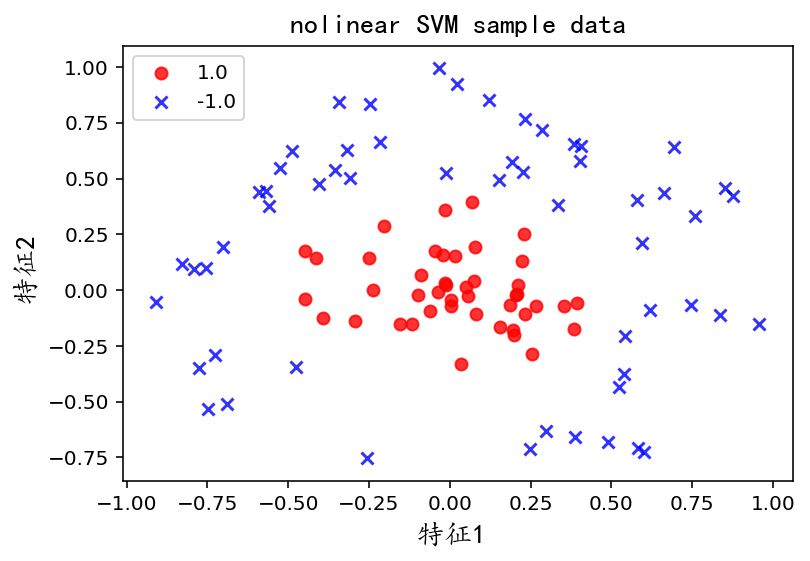

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.font_manager import FontProperties
font=FontProperties(fname=r'C:\Windows\Fonts\simkai.ttf',size=14)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


#导入数据
df=pd.read_table(r'E:\Repository\algorithms\nolinearsvmtest.txt',header=None)
X=df.iloc[:,[0,1]].values
y=df.iloc[:,-1].values
y.shape=(100,1)
#这一步的目的是将一维数组，转为二维数组，二维数组下就不能再y[:]这样进行索引

label=sorted(np.unique(y),reverse=True)

colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
#colors[:len(np.unique(y))]对应于不同类所要选择的颜色，二分类问题会在red,blue内进行选择
cmap = ListedColormap(colors[:len(np.unique(y))])
markers = ('o', 'x', 's', '^', 'v')
for idx,yi in enumerate(label):
        plt.scatter(x=X[y[:,0] == yi, 0], y=X[y[:,0] == yi, 1],
        alpha=0.8, c=cmap(idx),
        marker=markers[idx], label=yi)
plt.legend(loc='upper left')
plt.xlabel('特征1 ',fontproperties=font)
plt.ylabel('特征2 ',fontproperties=font)
plt.title('nolinear SVM sample data' ,fontproperties=font)
#plt.xlim(-2,11)
#plt.ylim(-7,5)
#plt.plot([0,8],[-4,4])#这样的方法可以画出直线
#y.shape


0.04 25 0.13


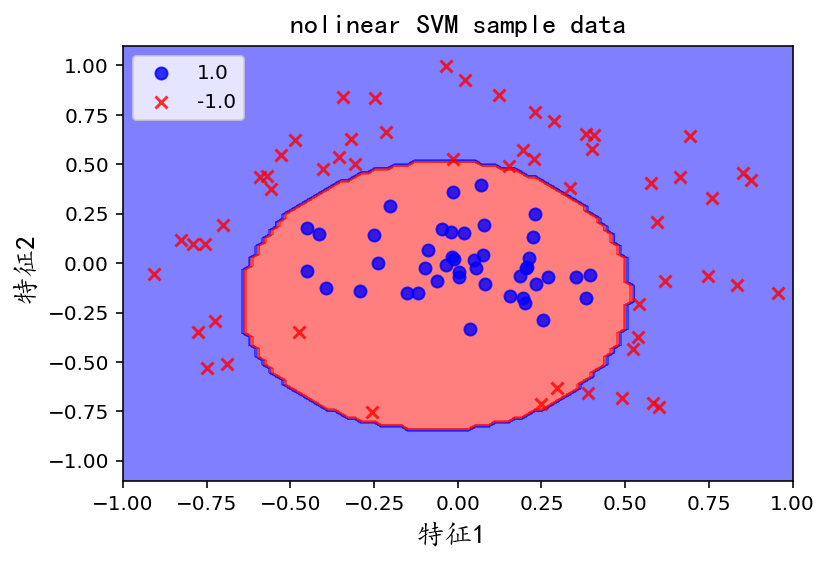

In [58]:
class SVM(object):
    
    
    #初始化，对各个按需要赋值
    def __init__(self,X,y,toler,C,maxIter):
        self.C=C
        self.toler=toler
        self.X=X
        self.y=y
        self.m=np.shape(self.X)[0]
        self.errorCache=np.zeros((self.m,2))
        #只要不是需要输入的，都可以定义在初始化里面，在初始化里面进行赋值
        self.alpha=np.zeros((self.m,1))
        self.b=0
        self.maxIter=maxIter
        self.kernel=np.zeros((self.m,self.m))#初始化可能要用到的kernel核,为之后计算做准备
        #初始化训练样本的核K(xi,xj),其中1.3为cigama值
        for i in range(self.m):
            self.kernel[:,i]=self.rbf_kernel(self.X,self.X[i,:],1.3)
            
    #选择rbf作为核函数，X为所以样本，x为其中一个样本，计算出来的是核矩阵中某一列的核值
    def rbf_kernel(self,X,x,cigama):
        k=np.zeros(self.m)#注，这里按矩阵应该为k=np.zeros((self.m,1))的二维数组，但上方self.kernel[:,i]是一维数组形式，
        #但二维数组不能直接对其赋值，所以采用了一维数组
        for q in range(self.m):
            delat=X[q,:]-x
            k[q]=np.dot(delat,delat)
        kernel=np.exp(-k/(2*cigama))
        return kernel
        

    #计算预测值与真实值之间的误差
    def error(self,i):#在类里面定义函数，加上一个self就可以引用self的属性了，不用再在括号里写self.m等
        alpha_y=(np.multiply(self.alpha,self.y)).T
        predicty=alpha_y.dot(self.kernel[:,i])+self.b
        error=predicty-self.y[i]
        return error
    #随机选择第二个待优化变量alphaj
    def select_random_alphaj(self,i,m):
        j=i
        while j==i:
            j=random.randint(0,m-1)
        return j
    
    
    #按启发式方法进行搜索第二个优化变量alphaj
    def select_heuristic_alphaj(self,i,Ei):
        maxk=-1
        max_dif_error=0
        Ej=0
        self.errorCache[i]=[1,Ei]#1代表有效位误差
        validerrorlist=np.nonzero(self.errorCache)[0]#np.non在二维数组下返回的是一个二维元祖，第一维为行索引号，第二维为列索引号
        if len(validerrorlist)>1:
            for k in validerrorlist:
                if k==i:
                    continue
                Ek=self.error(k)
                if abs(Ei-Ej)>max_dif_error:
                    maxk=k
                    Ej=Ek
                    max_dif_error=abs(Ei-Ej)
            return maxk,Ej
        else:
            j=select_random_alphaj(self,i,self.m)
            Ej=self.error(j)
            return j,Ej
            
    #更新误差缓存区
    def update_error(self,k):
        Ek=self.error(k)
        self.errorCache[k]=[1,Ek]
    
    #修剪alphaj
    def clip_alpha(self,alpha,H,L):
        if alpha>H:
            alpha=H
        elif alpha<L:
            alpha=L
        return alpha
    
    
    #找到alphai之后找alphaj的操作 
    def inner_loop(self,i):

        Ei=self.error(i)
        #步骤一：开始用启发式方法找alphaj
        #此Ei对应样本违反了KKT条件，选取它为第一个alpha1
        if ((Ei*self.y[i]<-self.toler) and self.alpha[i]<self.C) or ((Ei*self.y[i]>self.toler) and self.alpha[i]>0):


            #采用启发式优化算法寻找第二alpha2
            j,Ej=self.select_heuristic_alphaj(i,Ei)

            #对这两个alpha进行深度拷贝，便于后面修改
            alphaI_old=self.alpha[i].copy()
            alphaJ_old=self.alpha[j].copy()
            # 步骤二：计算上界和下界
            if self.y[i]==self.y[j]:
                H=min(self.C,alphaI_old+alphaJ_old)
                L=max(0,alphaI_old+alphaJ_old-self.C)
            else:
                H=min(self.C,self.C+alphaJ_old-alphaI_old)
                L=max(0,alphaJ_old-alphaI_old)
            if H==L:
            #print('H==L')
                return 0

            #步骤三：计算eta
            eta=self.kernel[i,i]+self.kernel[j,j]-2*self.kernel[i,j]
            if eta<=0:
            #print('eta<=0')
                return 0

            #步骤四：不考虑约束下修正alphaJ即alpha2
            self.alpha[j]=self.alpha[j]+(self.y[j]*(Ei-Ej))/eta
            #步骤五：修剪alphaJ
            self.alpha[j]=self.clip_alpha(self.alpha[j],H,L)
            #更新Ej
            self.update_error(j)
            if (abs(self.alpha[j]-alphaJ_old))<0.00001:
                #print('alphaJ变化太小')
                return 0
            #步骤六：修正alpha[i]
            self.alpha[i]=self.alpha[i]+self.y[i]*self.y[j]*(alphaJ_old-self.alpha[j])
            self.update_error(i)
            #步骤七：修正阈值b
            b1=-Ei-self.y[i]*np.dot(self.X[i],self.X[i])*(self.alpha[i]-alphaI_old)-self.y[j]*np.dot(self.X[i],self.X[j])*(self.alpha[j]-alphaJ_old)+self.b
            b2=-Ej-self.y[i]*np.dot(self.X[i],self.X[j])*(self.alpha[i]-alphaI_old)-self.y[j]*np.dot(self.X[j],self.X[j])*(self.alpha[j]-alphaJ_old)+self.b

            if 0<self.alpha[i]<self.C:
                self.b=b1
            elif 0<self.alpha[j]<self.C:
                self.b=b2
            else:
                self.b=(b1+b2)/2
            return 1
        else:

            return 0
    
    #完整的smo求解
    def smo(self):
    #初始迭代次数
        iterbegin=0
        entireSet = True
        alphaPairsChanged = 0
        while (iterbegin<self.maxIter) and ((alphaPairsChanged > 0) or (entireSet)):                            #遍历整个数据集都alpha也没有更新或者超过最大迭代次数,则退出循环
            alphaPairsChanged = 0
            if entireSet:                                                                                #遍历整个数据集                           
                for i in range(self.m):
                    alphaPairsChanged +=self.inner_loop(i)                                                  #使用优化的SMO算法
                    #print("全样本遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iterbegin,i,alphaPairsChanged))
                iterbegin += 1
            else:                                                                                         #遍历非边界值
                nonBoundIs = np.nonzero((self.alpha > 0) * (self.alpha < self.C))[0]                        #遍历不在边界0和C的alpha
                for i in nonBoundIs:

                    alphaPairsChanged += self.inner_loop(i) 
                    #print("非边界遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iterbegin,i,alphaPairsChanged))
                iterbegin += 1
            if entireSet:                                                                                #遍历一次后改为非边界遍历
                entireSet = False
            elif (alphaPairsChanged == 0):                                                                #如果alpha没有更新,计算全样本遍历
                entireSet = True 
            #print("迭代次数: %d" % iterbegin)
        return self.b,self.alpha                                                                             #返回SMO算法计算的b和alphas
    def get_w(self):
        alpha_y=(np.multiply(self.alpha,self.y)).T
        w=np.dot(alpha_y,self.X)
        return w

    def showclassifier(self):
        for idx,yi in enumerate(sorted(np.unique(self.y))):
            plt.scatter(x=self.X[self.y[:,0] == yi, 0], y=self.X[self.y[:,0] == yi, 1],
            alpha=0.8, c=cmap(idx),
            marker=markers[idx], label=yi)
        w1=w[0,0]
        w2=w[0,1]
        xmin=self.X.min(axis=0)[0]
        xmax=self.X.max(axis=0)[0]
        y1=(-b-w1*xmin)/w2
        y2=(-b-w1*xmax)/w2
        plt.plot([xmin,xmax],[y1,y2])
        #plt.xlim(-2,11)
        #plt.ylim(-7,5)
        for i, alpha in enumerate(self.alpha):
            if 0<abs(alpha) <0.6:
                x, y = self.X[i]
                plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='black')
    
    
    def test(self):#定义测试函数，测试训练出来的svm模型的准确度
        errornum=0
        alpha_y=(np.multiply(self.alpha,self.y)).T
        for i in range(self.m):
            predict=np.where((alpha_y.dot(self.kernel[:,i])+self.b)>0,1,-1)
            if predict!=y[i,0]:
                errornum+=1
        return errornum/self.m
    #给出训练SVM模型中支持向量的个数
    def numsvmpoint(self):
        num=0
        for i in self.alpha:
            if i>0.0001:
                num+=1
        return num

    def real_test(self):
        #载入测试集数据
        #注在测试集上验证的时候，用的是原来的w，b，注意有kerrnel时不要搞混
        df1=pd.read_table(r'E:\Repository\algorithms\nolinearsvmrealtest.txt',header=None)
        X1=df1.iloc[:,[0,1]].values
        m1=X1.shape[0]
        y1=df1.iloc[:,-1].values
        
        y1.shape=(100,1)
        #初始化错误率
        errornum=0
        #计算kernel
        kernel=np.zeros((self.m,m1))#初始化可能要用到的kernel核
        for i in range(m1):
            kernel[:,i]=self.rbf_kernel(self.X,X1[i,:],1.3)   
        alpha_y=(np.multiply(self.alpha,self.y)).T
        for i in range(m1):
            predict=np.where((alpha_y.dot(kernel[:,i])+self.b)>0,1,-1)
            if predict!=y1[i,0]:
                errornum+=1
        return errornum/m1
    #尝试画出决策面               
    def plot_decision_region(self,resolution=0.02):

        #找出各个样本的最值，分界面由权重决定，对x1,x2进行放缩并不会影响分界面，但可以使分界面更美观
        x1_min,x2_min=self.X[:,0].min()-1,self.X[:,1].min()-1
        x1_max,x2_max=self.X[:,0].max()+1,self.X[:,1].max()+1
        #print(x1_min)
        #将向量矩阵变为坐标矩阵
        xx1,xx2=np.meshgrid(np.arange(x1_min,x1_max,resolution),np.arange(x2_min,x2_max,resolution))
        #print(xx1)
        #Z是分界决策面所对应的分类决策，+1，-1将其对应于 contourf的等高线绘制高度，进而进行填充，画出分界区域
        Z=np.array([xx1.ravel(),xx2.ravel()]).T
        m2=Z.shape[0]
        kernel=np.zeros((self.m,m2))#初始化可能要用到的kernel核, 核的大小由w和样本测试数据量决定，w决定行宽，样本数据量决定列宽
        for i in range(m2):
            kernel[:,i]=self.rbf_kernel(self.X,Z[i,:],1.3)   
        alpha_y=(np.multiply(self.alpha,self.y)).T
        #for i in range(m1):
        Z=np.where((alpha_y.dot(kernel)+self.b)>0,1,-1)
        #高度需要与contourf(x,y,z)的维度相对应
        Z=Z.reshape(xx1.shape)
        #print(xx1.shape)
        #print(Z)

        colors = ('blue', 'red', 'lightgreen', 'gray', 'cyan')
        #colors[:len(np.unique(y))]对应于不同类所要选择的颜色，二分类问题会在red,blue内进行选择
        cmap = ListedColormap(colors[:len(np.unique(y))])
        #其中的alpha参数设置颜色填充的透明度
        #plt.contourf(xx1, xx2, Z, alpha=0.5, cmap=cmap)
        plt.contourf(xx1, xx2, Z, alpha=0.5, cmap=cmap)
        #设定所画图形界面
        plt.xlim(-1, 1)
        plt.ylim(-1.1,1.1)
        markers = ('o', 'x', 's', '^', 'v')
        
        for idx,yi in enumerate(label):
            plt.scatter(x=X[y[:,0] == yi, 0], y=X[y[:,0] == yi, 1],
            alpha=0.8, c=cmap(idx),
            marker=markers[idx], label=yi)
        plt.legend(loc='upper left')
        plt.xlabel('特征1 ',fontproperties=font)
        plt.ylabel('特征2 ',fontproperties=font)
        plt.title('nolinear SVM sample data' ,fontproperties=font)

if __name__=='__main__':
    supersvm=SVM(X,y,0.0001,200,100)
    b,alpha=supersvm.smo()
    errorrate=supersvm.test()
    svmnumpoint=supersvm.numsvmpoint()
    testseterrorrate=supersvm.real_test()
    #w=supersvm.get_w()
    #supersvm.showclassifier()
    #print(b)
    supersvm.plot_decision_region(resolution=0.02)
    print(errorrate,svmnumpoint,testseterrorrate)
    
    
    
    
        
        